# Analysis on trained model

Dataset discretize with 100 Gaussian mixture clusters (mog_100.npy), 30 minute interval. Unfiltered.

## Requirements

- Pre-processed dataset with 100 clusters located at `{ROOT}/data/sh30-c100`
- Pre-processed dataset with 50 clusters located at `{ROOT}/data/sh30-c50`
- Pre-computed 50 clusters located at `{ROOT}/data/exploratory_analysis/mog_50.npy`
- Pre-computed 100 clusters located at `{ROOT}/data/exploratory_analysis/mog_100.npy`
- Trained model at `{ROOT}/src/ml/checkpoints/sh30-c100_best.pt`

## import and constants

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import tqdm
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from src.path import ROOT
from src.ml.checkpoint import Checkpoint

# trajectory length
SEQ_LENGTH: int = 48

# cuda flag
USE_CUDA: bool = True

if USE_CUDA and not torch.cuda.is_available():
    USE_CUDA = False
    print('fallback to cpu as CUDA is not available on this device')

CHECKPOINT_PREFIX: str = 'sh30-c100'
CACHE_PREFIX: str = 'sh30-c100'

checkpoint = Checkpoint(
    checkpoint_interval=5,
    prefix=CHECKPOINT_PREFIX
)

## define dataset

### define path

Change the path variable here if you place your dataset files in a different location.

In [2]:
cluster_path = f'{ROOT}/exploratory_analysis/mog_100.npy'
dataset_path = str(ROOT.joinpath('data/sh30-c100'))

### split dataset

Split to pre-defined training set and test set.

In [3]:
import os
from datetime import date

from src.data_preprocess.trajectory import from_dataframe
from src.ml.dataset import get_shanghai_date

file_list = os.listdir(dataset_path)

def is_test(fname: str):
    '''
    returns True if file belongs to test set
    '''
    fdate = get_shanghai_date(fname)
    ref_date = date(2014, 6, 18)
    return fdate >= ref_date and (fdate - ref_date).days < 15


test_files = [fname for fname in file_list if is_test(fname)]
train_files = [fname for fname in file_list if not is_test(fname)]

### read basestations

In [4]:
from src.ml.dataset import create_point_to_class_map

all_candidates = torch.tensor(np.load(cluster_path), dtype=torch.float32)

point_to_class_map = create_point_to_class_map(all_candidates)

### load dataset

Load dataset files into in-memory tensors.

In [5]:
from torch.utils.data import random_split

from src.ml.dataset import TrajectoryDataset, get_shanghai_date, CACHE_PATH

def read_file(fname: str):
    df = pd.read_csv(f'{dataset_path}/{fname}')
    return get_shanghai_date(fname), [*from_dataframe(df, SEQ_LENGTH).values()]
    

train_set = TrajectoryDataset(sequence_length=SEQ_LENGTH, point_to_class_map=point_to_class_map)

if os.path.exists(f'{CACHE_PATH}/{CACHE_PREFIX}_train_data.pt'):
    train_set.load(f'{CACHE_PATH}/{CACHE_PREFIX}_train_data.pt')
else:
    train_set.read_files(
        train_files,
        read_file=read_file
    )

    train_set.save(f'{CACHE_PATH}/{CACHE_PREFIX}_train_data.pt')

# fix seed for reproducibility
train_set, valid_set = random_split(train_set, [0.8, 0.2], torch.Generator().manual_seed(123))

test_set = TrajectoryDataset(sequence_length=SEQ_LENGTH, point_to_class_map=point_to_class_map)

if os.path.exists(f'{CACHE_PATH}/{CACHE_PREFIX}_test_data.pt'):
    test_set.load(f'{CACHE_PATH}/{CACHE_PREFIX}_test_data.pt')
else:
    test_set.read_files(
        test_files,
        read_file=read_file
    )

    test_set.save(f'{CACHE_PATH}/{CACHE_PREFIX}_test_data.pt')

### Define pre-process pipeline

1. convert to Cartesian coordinates by tangent plane project. Choose center of plane (reference point) to be median of lat-long.
2. normalize to [-1, +1] for better gradients

In [6]:
from src.ml.utils import create_shanghai_preprocessor, to_cartesian

ref_lat = all_candidates[:, 0].median()
ref_long = all_candidates[:, 1].median()

all_candidates_cart = to_cartesian(all_candidates, ref_point=(ref_lat, ref_long))
min_x, max_x = all_candidates_cart[:, 0].min().item(), all_candidates_cart[:, 0].max().item()
min_y, max_y = all_candidates_cart[:, 1].min().item(), all_candidates_cart[:, 1].max().item()
del all_candidates_cart

preprocess = create_shanghai_preprocessor(
    x_range=(min_x, max_x),
    y_range=(min_y, max_y),
    ref_point=(ref_lat, ref_long)
)

## evaluation

### load best model

In [7]:
from src.ml.checkpoint import DEFAULT_CHECKPOINT_DIR
from src.ml.model import TrajectoryModel
from src.ml.model.modules import BaseStationEmbedding, TransformerTrajectoryEncoder

model_dim = 128

best_model = TrajectoryModel(
    base_station_embedding=BaseStationEmbedding(
        feat_dim=(2, 64),
        context_dim=(31, 48),
        out_dim=model_dim,
        layer_norm=True
    ),
    trajectory_encoder=TransformerTrajectoryEncoder(
        in_dim=model_dim,
        max_len=SEQ_LENGTH,
        hid_dim=(model_dim, model_dim * 2, 8),
        do_prob=0.2,
        n_blocks=4,
        #layer_norm=True
    ),
)

best_state = torch.load(f'{DEFAULT_CHECKPOINT_DIR}/{CHECKPOINT_PREFIX}_best.pt')

best_model.load_state_dict(best_state['model'])
best_model.eval()

TrajectoryModel(
  (base_station_embedding): BaseStationEmbedding(
    (feature_mixer): Sequential(
      (0): MLPBlock(
        (0): Linear(in_features=2, out_features=64, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.0, inplace=False)
      )
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (context_mixer): Sequential(
      (0): MLPBlock(
        (0): Linear(in_features=31, out_features=48, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.0, inplace=False)
      )
      (1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
    )
    (output_mixer): MLPBlock(
      (0): Linear(in_features=112, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (trajectory_encoder): TransformerTrajectoryEncoder(
    (pe): PositionalEncoding(
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (seq_model): TransformerEncoder(
      (layers):

### plot training curves

#### training loss

Text(0, 0.5, 'loss')

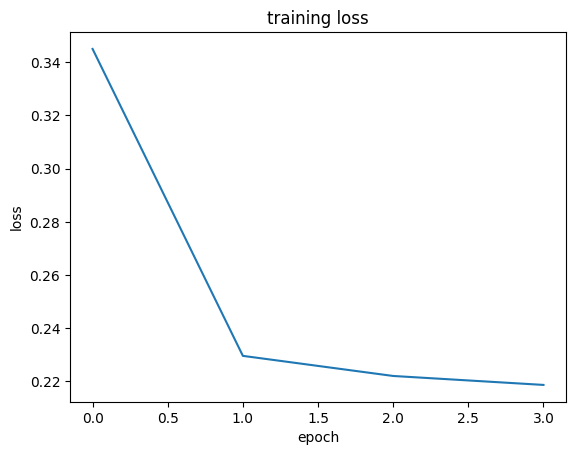

In [8]:
plt.figure()
plt.plot([*range(len(best_state['train_stats']))], np.array(best_state['train_stats'])[:, 1])
plt.title('training loss')
plt.xlabel('epoch')
plt.ylabel('loss')

#### perplexity

Text(0, 0.5, 'perplexity')

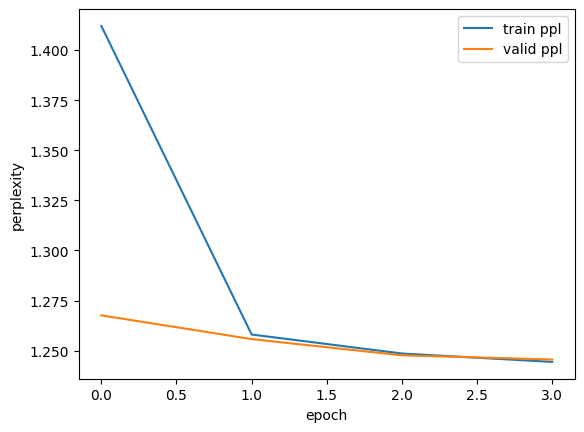

In [9]:
ax = plt.subplot()

plt.plot(
    [*range(len(best_state['train_stats']))], 
    [math.exp(stats[0]) for stats in best_state['train_stats']], 
    label='train ppl'
)

plt.plot(
    [*range(len(best_state['valid_stats']))], 
    [math.exp(stats[0]) for stats in best_state['valid_stats']], 
    label='valid ppl'
)

plt.legend()
plt.xlabel('epoch')
plt.ylabel('perplexity')

### basestation similarity in different timestamps

Model expects more user activity from 07:00 am to 20:00 pm.

C:\Users\chinp\AppData\Local\Temp\ipykernel_35016\2041116095.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


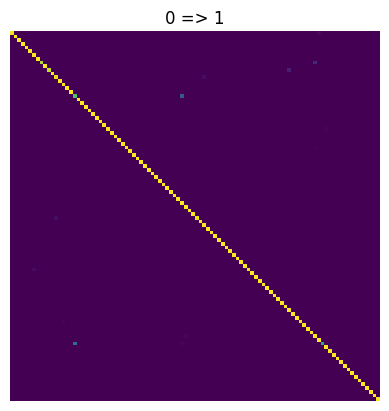

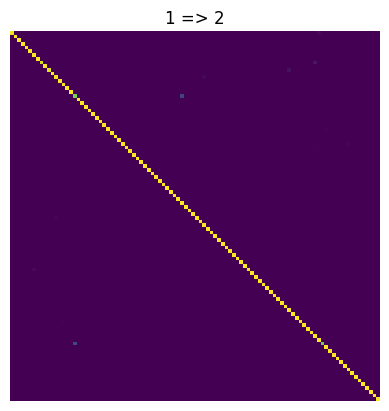

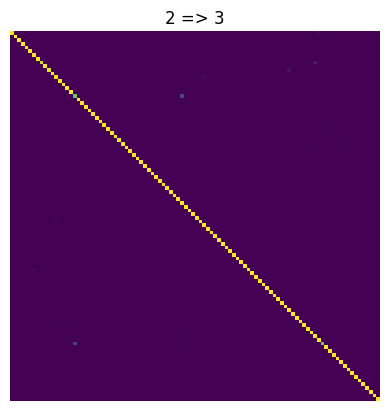

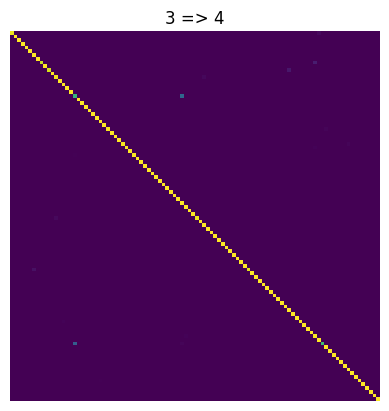

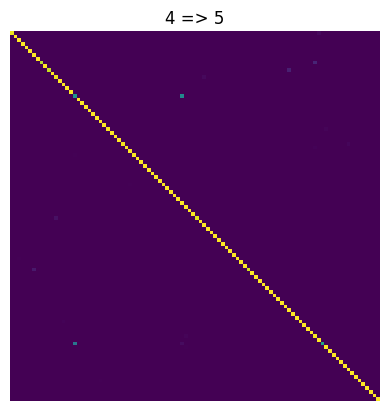

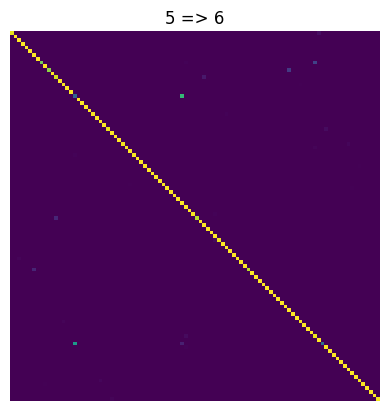

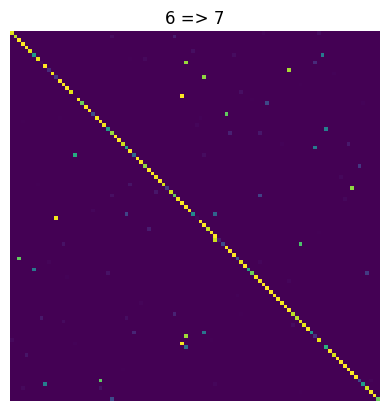

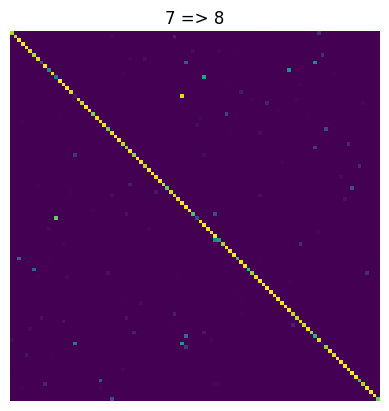

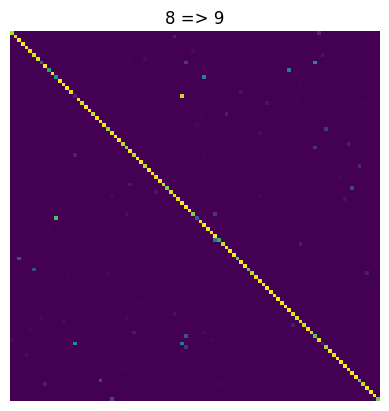

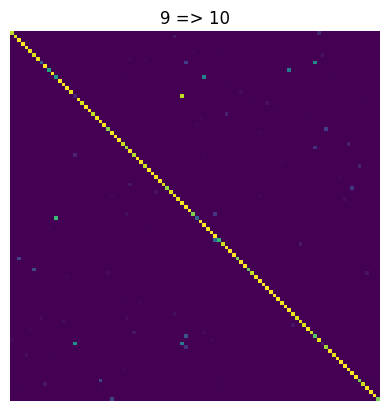

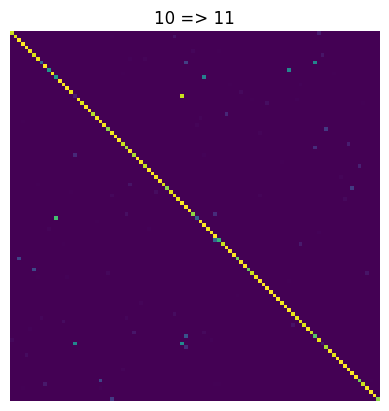

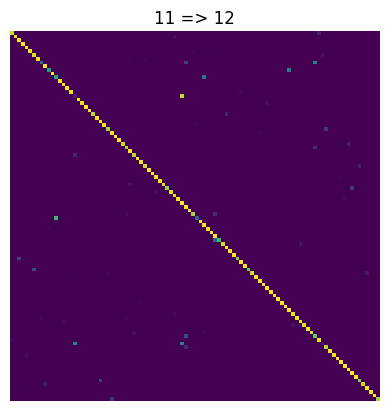

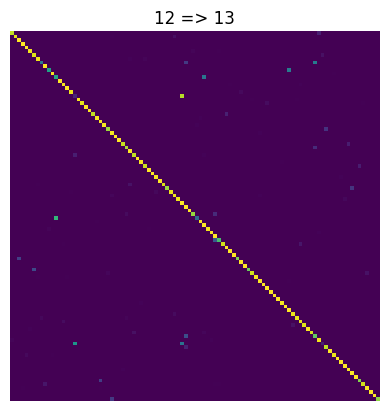

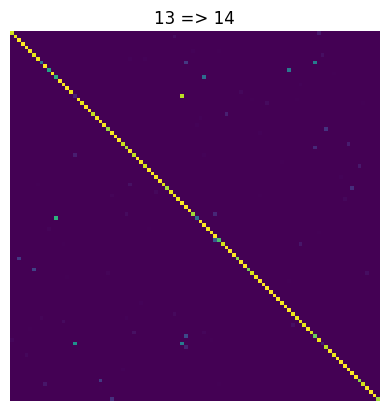

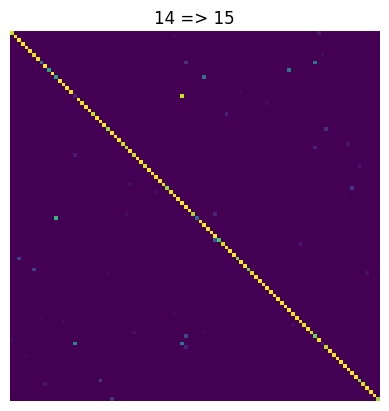

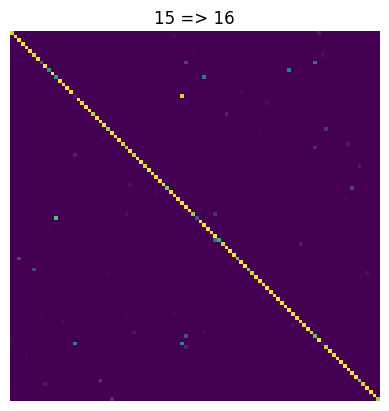

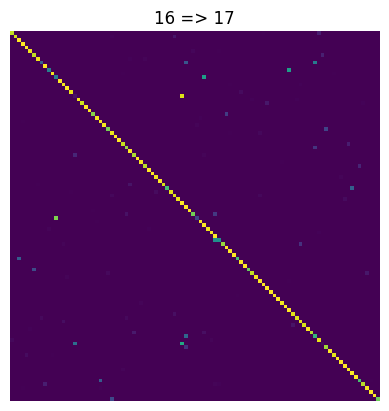

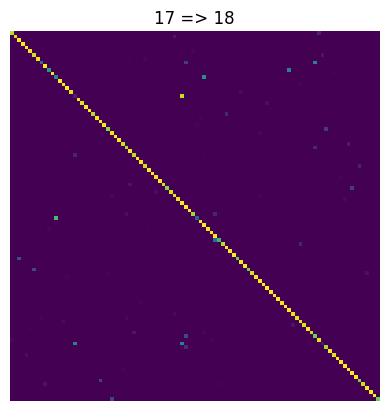

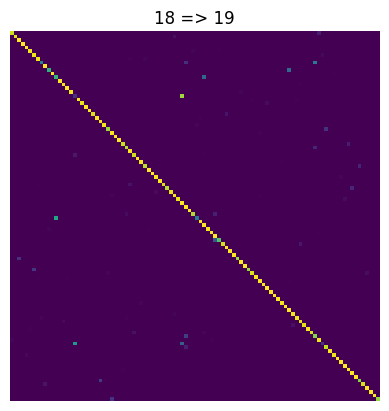

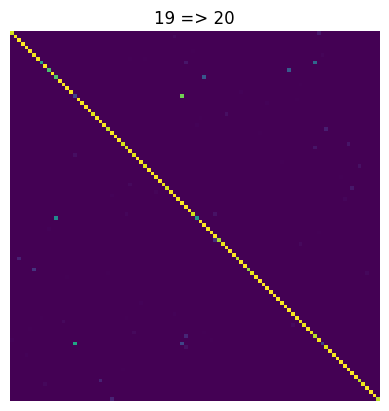

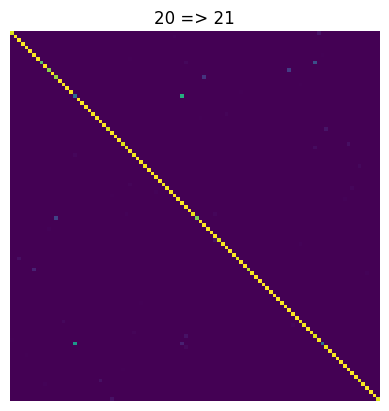

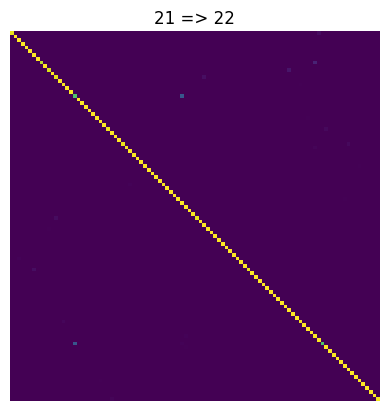

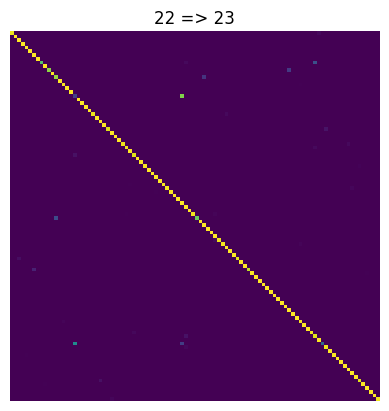

In [10]:
best_model.cpu()
processed_candidates = preprocess(all_candidates)
processed_candidates = processed_candidates.cpu()

with torch.no_grad():
    for i in range(1, 24):
        context = torch.concat((
            F.one_hot(torch.tensor([i-1]), 24), 
            F.one_hot(torch.tensor([0]), 7)), 
        dim=-1).repeat(100, 1).float()
        bs0 = best_model.base_station_embedding(processed_candidates, context)

        context = torch.concat((
            F.one_hot(torch.tensor([i]), 24), 
            F.one_hot(torch.tensor([0]), 7)
        ), dim=-1).repeat(100, 1).float()
        bs1 = best_model.base_station_embedding(processed_candidates, context)

        dp = F.softmax(bs0 @ bs1.T, dim=-1).numpy()

        plt.figure()
        plt.title(f'{i-1} => {i}')
        plt.axis('off')
        plt.imshow(dp)

#### compare this with movement statistics in the training set

Seems like the embedding model expect more movement after 6:00 am. Lets compare this with the movement statistics in the training set...

100%|██████████| 408398/408398 [02:33<00:00, 2654.34it/s]


Text(0, 0.5, 'frequency')

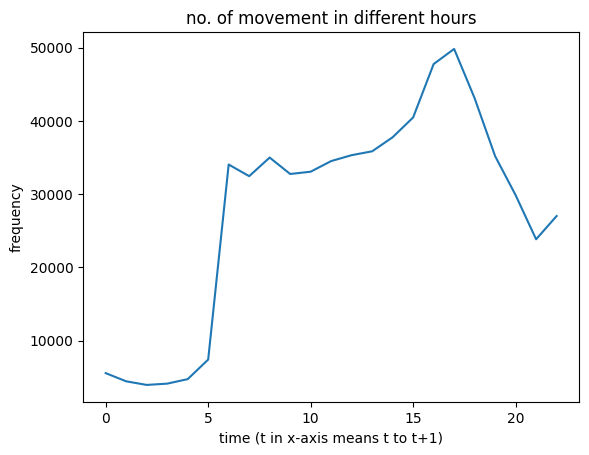

In [11]:
movement_count = np.zeros(23)

for trajectory, context, target in tqdm.tqdm(train_set):
    diff: torch.FloatTensor = target[1:-1] != target[:-2]
    movement_count += np.bincount(np.arange(SEQ_LENGTH - 2) // 2, diff.int().numpy())

plt.plot(np.arange(23), movement_count)
plt.title('no. of movement in different hours')
plt.xlabel('time (t in x-axis means t to t+1)')
plt.ylabel('frequency')

### first layer attention scores

We observed that a high attention score is assigned to the [BOS] token, this is a common pattern in transformer models.

tensor([[28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
         38, 38, 38, 38, 38, 38, 38, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
         28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28]])
tensor(757.9285, device='cuda:0')
tensor(0.9375)


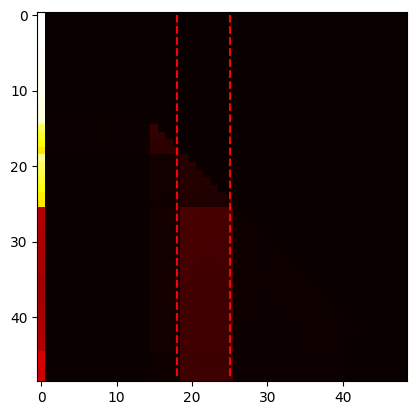

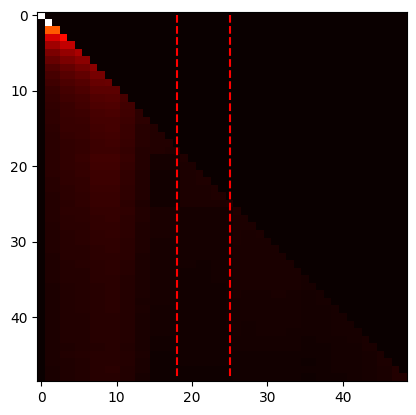

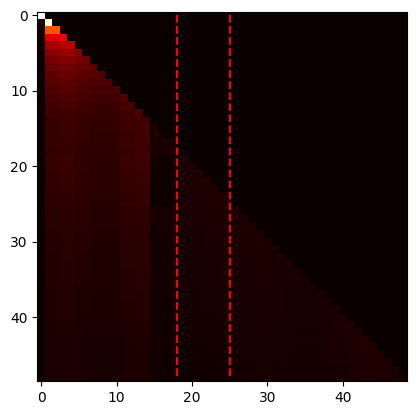

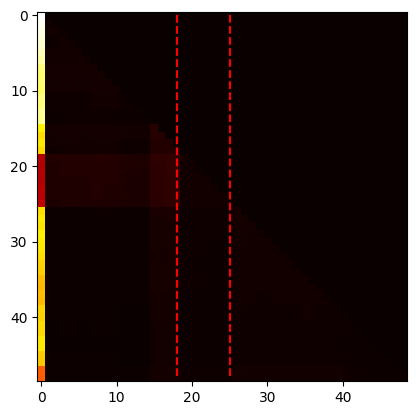

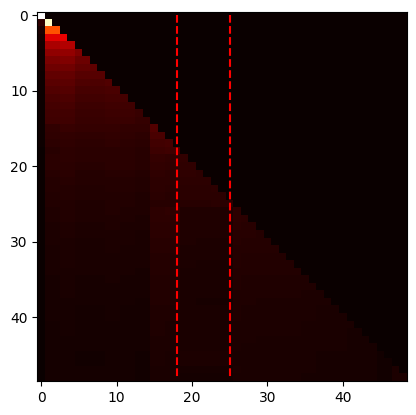

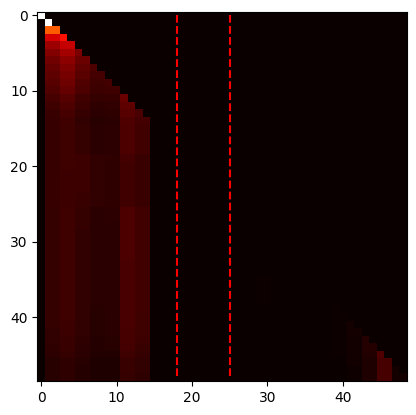

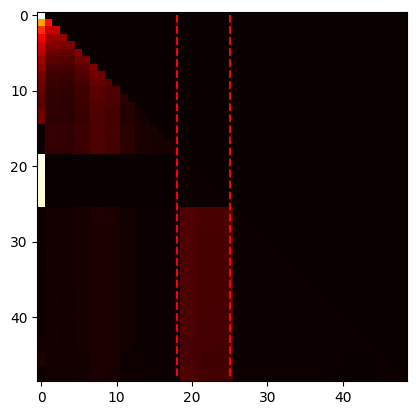

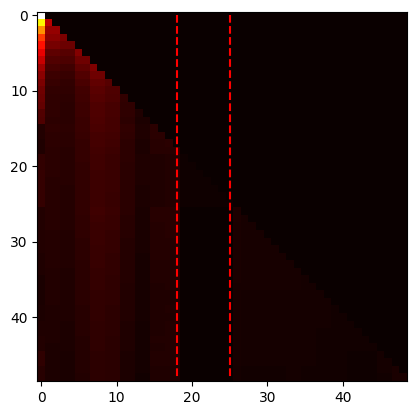

In [35]:
from src.ml.utils import mean_deviation, accuracy

best_model.cpu()
processed_candidates = processed_candidates.cpu()

with torch.no_grad():
    idx = random.randrange(0, len(valid_set))

    trajectory, context, target = valid_set[idx]
    trajectory: torch.FloatTensor = trajectory.unsqueeze(0)
    context: torch.FloatTensor = context.unsqueeze(0)
    target: torch.IntTensor = target.unsqueeze(0)

    trajectory = preprocess(trajectory)
    trajectory_embedding = torch.concat((
        best_model.trajectory_encoder.bos, 
        best_model.base_station_embedding(trajectory, context)
    ), dim=1)

    _, attn_scores = best_model.trajectory_encoder.seq_model.layers[0].self_attn(
        trajectory_embedding, 
        trajectory_embedding, 
        trajectory_embedding,
        attn_mask=nn.Transformer.generate_square_subsequent_mask(SEQ_LENGTH + 1),
        is_causal=True,
        average_attn_weights=False,
    )

    for head in range(8):
        plt.figure()
        plt.imshow(attn_scores[0, head].numpy(), cmap='hot')

        for i, val in enumerate((target[0, 1:] != target[0, :-1]).tolist()):
            # highlight change in basestation
            if val:
                plt.plot([i + 1, i + 1], [0, SEQ_LENGTH], 'r--')

    print(target)
    
    logits = best_model(context[:, :-1], trajectory[:, :-1], processed_candidates, context)

    print(mean_deviation(logits, target, all_candidates.cuda()))

    print(accuracy(logits, target))


### generative capability

Examine generative capability of the model

#### Visualization

- Blue: sample at each step
- Red: greedy, take max probability at each step
- Green: original data

In [38]:
from src.plot import get_shanghai_map, plot_trajectory
from src.data_preprocess.trajectory import Trajectory

best_model.cpu()
processed_candidates = processed_candidates.cpu()

with torch.no_grad():
    idx = random.randrange(0, len(valid_set))

    trajectory, context, target = valid_set[idx]
    raw_trajectory: torch.FloatTensor = trajectory.unsqueeze(0)
    context: torch.FloatTensor = context.unsqueeze(0)
    target: torch.IntTensor = target.unsqueeze(0)

    raw_trajectory_sample = raw_trajectory[0, :1]
    raw_trajectory_greedy = raw_trajectory[0, :1]

    trajectory = preprocess(raw_trajectory)

    logits = best_model(context[:, :1], trajectory[:, :1], processed_candidates, context[:, :1])

    current_trajectory_sample = trajectory[:, :1]
    current_trajectory_greedy = trajectory[:, :1]
    
    for i in range(1, 48):
        logits = best_model(context[:, :i], current_trajectory_sample, processed_candidates, context[:, :i+1])
        logits = logits[0, -1]

        sample = torch.multinomial(logits.softmax(dim=-1), 1)

        current_trajectory_sample = torch.concat((
            current_trajectory_sample,
            processed_candidates[sample, :][None]
        ), dim=1)

        raw_trajectory_sample = torch.concat((
            raw_trajectory_sample, 
            all_candidates[sample, :]
        ), dim=0)

        greedy = logits.softmax(dim=-1).argmax(dim=-1)

        current_trajectory_greedy = torch.concat((
            current_trajectory_greedy,
            processed_candidates[[greedy], :][None]
        ), dim=1)

        raw_trajectory_greedy = torch.concat((
            raw_trajectory_greedy, 
            all_candidates[[greedy], :]
        ), dim=0)
        
        
    trajectory_class_sample = Trajectory([None] * SEQ_LENGTH)

    for i, point in enumerate(raw_trajectory_sample.tolist()):
        trajectory_class_sample.points[i] = tuple(point)

    trajectory_class_greedy = Trajectory([None] * SEQ_LENGTH)

    for i, point in enumerate(raw_trajectory_greedy.tolist()):
        trajectory_class_greedy.points[i] = tuple(point)

    trajectory_class_data = Trajectory([None] * SEQ_LENGTH)

    for i, point in enumerate(raw_trajectory[0].tolist()):
        trajectory_class_data.points[i] = tuple(point)

    map = get_shanghai_map()
    plot_trajectory(trajectory_class_sample, 'blue', map, marker=False)
    plot_trajectory(trajectory_class_greedy, 'red', map, marker=False)
    plot_trajectory(trajectory_class_data, 'green', map, marker=False)

print(trajectory_class_data.similarity(trajectory_class_greedy))
map

0.3333333333333333


#### Quatitative analysis

Accuracy of generative prediction: greedily append most likely token similar to sentence completion in NLP.

In [39]:
from torch.utils.data.dataloader import DataLoader
from src.ml.utils import haversine

if USE_CUDA:
    best_model.cuda()
    processed_candidates = processed_candidates.cuda()

accuracy = 0
recovery_error = 0

valid_loader = DataLoader(valid_set, batch_size=64)

with torch.no_grad():
    for trajectory, context, target in tqdm.tqdm(valid_loader):
        raw_trajectory: torch.FloatTensor = trajectory
        context: torch.FloatTensor = context
        target: torch.IntTensor = target

        if USE_CUDA:
            raw_trajectory = raw_trajectory.cuda()
            context = context.cuda()
            target = target.cuda()

        current_trajectory = preprocess(raw_trajectory[:, :1])
        current_idx = target[:, :1]

        for i in range(1, SEQ_LENGTH):
            logits = best_model.forward(context[:, :i], current_trajectory, processed_candidates, context[:, :i + 1])[:, -1]
            next_idx = logits.softmax(dim=-1).argmax(dim=-1)

            next_token = processed_candidates[next_idx, :]

            current_trajectory = torch.concat((
                current_trajectory,
                next_token[:, None]
            ), dim=1)

            current_idx = torch.concat((
                current_idx,
                next_idx[:, None]
            ), dim=1)
            
        accuracy += (current_idx == target).float().mean().item()

        if USE_CUDA:
            current_idx = current_idx.cpu()
            target = target.cpu()

        recovery_error += haversine(
            all_candidates[current_idx.view(-1)],
            all_candidates[target.view(-1)]
        ).mean().item()

print(f'accuracy: {accuracy / len(valid_loader)}')
print(f'recovery error: {recovery_error / len(valid_loader)}')

  0%|          | 0/1596 [00:00<?, ?it/s]c:\Users\chinp\source\capstone-project-9900w16aaiadvance\venv\lib\site-packages\torch\nn\modules\transformer.py:685: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  return torch._transformer_encoder_layer_fwd(
100%|██████████| 1596/1596 [15:24<00:00,  1.73it/s]

accuracy: 0.7974021074392443
recovery error: 2724.1900934587447


### Locality prediction.

Compute intersection over union similarity of top-k predicted by model and k-nearest base stations. Choose k = 10.

#### compute average IoU of k-NN for each base station.

Compare k-NN from Euclidean distance and cosine similarity of embeddings.

In [88]:
from src.ml.utils import haversine

best_model.cpu()
processed_candidates = processed_candidates.cpu()

# all pairs distance, then compute k-nearest
_, indices_d = haversine(
    all_candidates.repeat_interleave(100, dim=0).reshape(-1, 2), 
    all_candidates.repeat(100, 1)
).reshape(100, 100).topk(k=10, dim=-1, largest=False)
indices_d = indices_d.tolist()

iou_sum = 0
count = 0

with torch.no_grad():
    for week in range(7):
        for hr in range(24):
            context = torch.concat((
                F.one_hot(torch.tensor([hr]), 24), 
                F.one_hot(torch.tensor([week]), 7)), 
            dim=-1).repeat(100, 1).float()

            bs0 = best_model.base_station_embedding(processed_candidates, context)

            _, indices_p = F.softmax(bs0 @ bs0.T, dim=-1).topk(k=10, dim=-1)
            indices_p = indices_p.tolist()

            for s0, s1 in zip(indices_p, indices_d):
                iou_sum += len(set(s0).intersection(s1)) / len(set(s0).union(s1))
                count += 1

print(iou_sum / count)

0.6903140906712202


#### randomly select trajectory and timestamp

In [51]:
from src.ml.utils import haversine

best_model.cpu()
processed_candidates = processed_candidates.cpu()

with torch.no_grad():
    idx = random.randrange(0, len(valid_set))

    trajectory, context, target = valid_set[idx]
    raw_trajectory: torch.FloatTensor = trajectory.unsqueeze(0)
    context: torch.FloatTensor = context.unsqueeze(0)
    target: torch.IntTensor = target.unsqueeze(0)

    trajectory = preprocess(raw_trajectory)

    split_point = random.randrange(1, SEQ_LENGTH)

    logits = best_model.forward(
        context[:, :split_point], 
        trajectory[:, :split_point], 
        processed_candidates, 
        context[:, :split_point + 1]
    )

    # prediction equal to ground truth
    print(logits[0, -1].softmax(dim=-1).argmax(dim=-1) == target[0, split_point])
    
    # prediction
    values_p, indices_p = logits[0, -1].softmax(dim=-1).topk(k=10, dim=-1)

    values_d, indices_d = haversine(raw_trajectory[:, split_point - 1], all_candidates).topk(k=10, dim=0, largest=False)

    indices_d = indices_d.tolist()
    indices_p = indices_p.tolist()

    # IoU of top-k probabilities and k-nearest neighbors
    print(len(set(indices_d).intersection(indices_p)) / len(set(indices_d).union(indices_p)))

tensor(True)
0.8181818181818182


### Embedding quality (perturbation resistant)

Examine spatio-locality of model. Will model generalize to unseen basestations?

We perturb the all_candidates tensor and see if predicted probabilities are similar by using the IoU similarity metric.

#### average IoU of k-most similar tokens

Compute IoU of k-most similar tokens of a base station and perturbed base station.

In [48]:
best_model.cpu()
processed_candidates = processed_candidates.cpu()

iou_sum = 0
count = 0

with torch.no_grad():
    for week in range(7):
        for hr in range(24):
            context = torch.concat((
                F.one_hot(torch.tensor([hr]), 24), 
                F.one_hot(torch.tensor([week]), 7)), 
            dim=-1).repeat(100, 1).float()

            # perturb
            perturbed_candidates = all_candidates + torch.randn_like(all_candidates) * 0.01

            bs0 = best_model.base_station_embedding(processed_candidates, context)
            bs1 = best_model.base_station_embedding(preprocess(perturbed_candidates), context)

            values_o, indices_o = F.softmax(bs0 @ bs0.T, dim=-1).topk(k=10, dim=-1)
            values_p, indices_p = F.softmax(bs0 @ bs1.T, dim=-1).topk(k=10, dim=-1)

            indices_o = indices_o.tolist()
            indices_p = indices_p.tolist()
            
            for s0, s1 in zip(indices_o, indices_p):
                iou_sum += len(set(s0).intersection(s1)) / len(set(s0).union(s1))
                count += 1

print(iou_sum / count)            

0.8766100169672134


#### randomly select a spatial temporal point and compare k-nearest neighbors

Select trajectory and timestamp at random.

In [43]:
best_model.cpu()
processed_candidates = processed_candidates.cpu()

with torch.no_grad():
    idx = random.randrange(0, len(valid_set))

    trajectory, context, target = valid_set[idx]
    raw_trajectory: torch.FloatTensor = trajectory.unsqueeze(0)
    context: torch.FloatTensor = context.unsqueeze(0)
    target: torch.IntTensor = target.unsqueeze(0)

    trajectory = preprocess(raw_trajectory)

    split_point = random.randrange(1, SEQ_LENGTH)

    # perturb
    perturbed_candidates = all_candidates + torch.randn_like(all_candidates) * 0.01

    logits = best_model.forward(
        context[:, :split_point], 
        trajectory[:, :split_point], 
        processed_candidates, 
        context[:, :split_point + 1]
    )

    print(logits[0, -1].softmax(dim=-1).argmax(dim=-1) == target[0, split_point])

    perturbed_logits = best_model.forward(
        context[:, :split_point], 
        trajectory[:, :split_point], 
        preprocess(perturbed_candidates), 
        context[:, :split_point + 1]
    )

    print(perturbed_logits[0, -1].softmax(dim=-1).argmax(dim=-1) == target[0, split_point])
    
    # prediction
    values_o, indices_o = logits[0, -1].softmax(dim=-1).topk(k=10, dim=-1)
    values_p, indices_p = perturbed_logits[0, -1].softmax(dim=-1).topk(k=10, dim=-1)

    indices_o = indices_o.tolist()
    indices_p = indices_p.tolist()

    # IoU of top-k probabilities and k-nearest neighbors
    print(len(set(indices_o).intersection(indices_p)) / len(set(indices_o).union(indices_p)))

tensor(True)
tensor(True)
0.8181818181818182


### Generalization to lower no. of clusters?

Will model generalize on dataset with 50 clusters?

### load clusters

In [89]:
all_candidates_50 = torch.tensor(np.load(f'{ROOT}/exploratory_analysis/mog_50.npy'), dtype=torch.float32)
point_to_class_map_50 = create_point_to_class_map(all_candidates_50)

### load dataset

In [91]:
dataset_50_path = f'{ROOT}/data/sh30-c50/'
train_files_50 = os.listdir(dataset_50_path)

def read_file_50(fname: str):
    df = pd.read_csv(f'{dataset_50_path}/{fname}')
    return get_shanghai_date(fname), [*from_dataframe(df, SEQ_LENGTH).values()]
    

train_set_50 = TrajectoryDataset(sequence_length=SEQ_LENGTH, point_to_class_map=point_to_class_map_50)

if os.path.exists(f'{CACHE_PATH}/sh30-c50_train_data.pt'):
    train_set_50.load(f'{CACHE_PATH}/sh30-c50_train_data.pt')
else:
    train_set_50.read_files(
        train_files,
        read_file=read_file_50
    )

    train_set_50.save(f'{CACHE_PATH}/sh30-c50_train_data.pt')

train_set_50, valid_set_50 = random_split(train_set_50, [0.8, 0.2], torch.Generator().manual_seed(123))

### run on dataset with 50 clusters

In [92]:
from torch.utils.data import DataLoader
from src.ml.utils import accuracy, mean_deviation

if USE_CUDA:
    best_model.cuda()
    all_candidates_50 = all_candidates_50.cuda()

processed_candidates_50 = preprocess(all_candidates_50)

acc = 0
recovery_error = 0

with torch.no_grad():
    valid_loader_50 = DataLoader(valid_set_50, batch_size=64, shuffle=False)

    for trajectory, context, target in tqdm.tqdm(valid_loader_50):
        raw_trajectory: torch.FloatTensor = trajectory
        context: torch.FloatTensor = context
        target: torch.IntTensor = target

        if USE_CUDA:
            raw_trajectory = raw_trajectory.cuda()
            context = context.cuda()
            target = target.cuda()

        trajectory = preprocess(raw_trajectory)

        logits = best_model.forward(context[:, :-1], trajectory[:, :-1], processed_candidates_50, context)

        acc += accuracy(logits, target).item()
        recovery_error += mean_deviation(logits.cpu(), target.cpu(), all_candidates_50).item()

    print(f'acuracy: {acc / len(valid_loader_50)}')
    print(f'recovery error: {recovery_error / len(valid_loader_50)}')

100%|██████████| 1596/1596 [00:47<00:00, 33.27it/s]

acuracy: 0.9505541096429777
recovery error: 717.3074334510287
